# Basis set in quantum chemistry

## Examples of atomic orbitals and plane waves

###### Germain Salvato-Vallverdu (germain.valverdu@univ-pau.fr)

This notebook is divided in X parts which have different purpose. The reader interested in atomic orbitals or plane waves basis could skip the first part which load python modules and define several functions used in the following.

* [Atomic orbitals](#Atomic-orbitals)
* [Plane waves basis set](#Plane-waves-basis-set)
* [Fit a 3s atomic orbital](#Fit-a-3s-atomic-orbital)

### Python stuff

Numpy and Scipy routines are used here and need to be imported.

In [1]:
import numpy as np
from scipy.misc import factorial
from scipy.optimize import curve_fit
import scipy.constants as cst

Matplotlib is used in order to make plots

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Bhor radius is defined in angstrom from scipy.constants module.

In [3]:
ao = cst.physical_constants["Bohr radius"][0] / cst.angstrom
print("a0 = {} A".format(ao))

a0 = 0.52917721092 A


A root mean square function is defined in order to measure the quality of the fit with plane waves.

In [4]:
def rms(y_th, y):
    """ compute the root mean square between y and y_th values """
    return np.sqrt(((np.array(y) - np.array(y_th))**2).mean())

### Atomic orbitals

We define the radial part of a 4s AO of an hydrogen like specie.

\begin{equation}
    \varphi_{4,0,0}(r) = 
    \frac{1}{96} \left(\frac{Z}{a_o}\right)^{3/2} 
    \left(24 - \frac{18 Z r}{a_o} + \frac{3 Z^2 r^2}{a_o^2} - \frac{Z^3 r^3}{8 a_o^3}\right) 
    \exp\left(-\frac{Z r}{4 a_o}\right)
\end{equation}

In [5]:
def OA4s(r, z=19, ao=ao):
    """ 
    Return values of the radial part of a 4s AO of an hydrogen like specie
    
    Args:
        r : float or ndarray of float in the same unit as ao (A by default)
        z (int) : atomic number
        ao (float): Bohr radius (in A by default)
    """
    poly = 24 - 18 * z * r / ao + 3 * z**2 * r**2 / ao**2 - z**3 * r**3 / (8 * ao**3)
    return (z / ao)**(3/2) / 96 * poly * np.exp(- z * r / (4 * ao))

We define the radial part of a 4s AO of an hydrogen like specie.

\begin{equation}
    \varphi_{3,0,0}(r) = 
    \frac{1}{9\sqrt{3}} \left(\frac{Z}{a_o}\right)^{3/2} 
    \left(6 - \frac{4 Z r}{a_o} + \frac{4 Z^2 r^2}{9 a_o^2}\right) 
    \exp\left(-\frac{Z r}{4 a_o}\right)
\end{equation}

In [6]:
def OA3s(r, z=11, ao=ao):
    """ 
    Return values of the radial part of a 3s AO of an hydrogen like specie
    
    Args:
        r : float or ndarray of float in the same unit as ao (A by default)
        z (int) : atomic number
        ao (float): Bohr radius (in A by default)
    """
    poly = 6 - 4 * z * r / ao + 4 * z**2 * r**2 / (9 * ao**2)
    return (z / ao)**(3/2) / (9. * np.sqrt(3)) * poly * np.exp(-z * r / (3 * ao))

For comparison we define also a slater type orbital :

\begin{equation}
    \varphi_{n,0,0}^{slater}(r) = \frac{1}{\sqrt{(2n)!}} \left(\frac{2 Z}{n a_o}\right)^{n+\frac{1}{2}}
    r^{n-1} \exp\left(-\frac{Z r}{n a_o}\right)
\end{equation}

In [7]:
def slater_ns(r, n=3, z=11, ao=ao):
    """ 
    Return values of the radial part of a slater type AO of an hydrogen like specie
    
    Args:
        r : float or ndarray of float in the same unit as ao (A by default)
        z (int) : atomic number
        ao (float): Bohr radius (in A by default)
    """
    fact = 1 / np.sqrt(factorial(2 * n)) * (2 * z / (n * ao))**(n + 0.5)
    return fact * r**(n-1) * np.exp(- z * r / (n * ao))

A smooth AO is defined for comparison, without oscillations closed to the nuclei.

In [8]:
def smooth_3s(r, c=14, alpha=1.9, ao=ao):
    """ 
    Return values of the radial part of a smooth AO without any oscillation closed to the nuclei.
    
    Args:
        r : float or ndarray of float in the same unit as ao (A by default)
        z (int) : atomic number
        ao (float): Bohr radius (in A by default)
    """
    return c * np.exp(- alpha * r / ao)

Make some simple plots for comparison. As expected, the slater type orbital is smoother than the solution of the hydrogen like one.

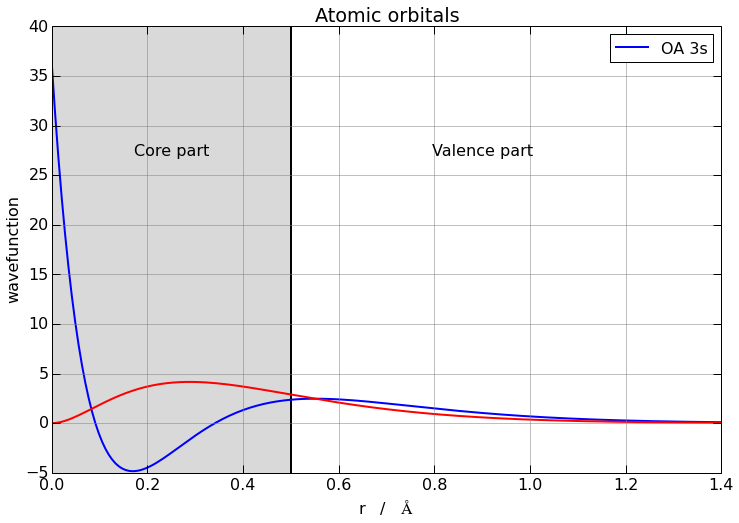

In [9]:
r = np.linspace(0, 1.4, 200)
plt.plot(r, OA3s(r, z=11), "b-", label="OA 3s", lw=2)
#plt.plot(r, smooth_3s(r), "m-", label="3s smooth", lw=2)
ymin, ymax = plt.ylim()
plt.title("Atomic orbitals")
plt.xlabel("r   /   $\AA$")
plt.ylabel("wavefunction")
plt.legend()
plt.savefig("orbitals_1.pdf")
plt.plot(r, slater_ns(r, n=3, z=11), "r-", label="Slater 3s", lw=2)
plt.vlines(0.5, ymin, ymax, lw=2)
plt.fill_between(x=[0, .5], y1=[ymin, ymin], y2=[ymax, ymax], color="k", alpha=.15)
plt.annotate("Core part", xy=(0.25, 27), horizontalalignment="center")
plt.annotate("Valence part", xy=(0.9, 27), horizontalalignment="center")
plt.savefig("orbitals_2.pdf")

### Plane waves basis set

#### Definition

Plane waves basis functions are used in conjunction with periodic boundary conditions. In such case, one define a direct lattice $\left\lbrace \vec{a}_i\right\rbrace_{i=1,3}$ corresponding to the cell into which calculations is done. Direct vectors are expressed as :

\begin{align}
    \vec{r} & = r_1 \vec{a}_1 + r_2 \vec{a}_2 + r_3 \vec{a}_3 \\ & = x \vec{i} + y \vec{j} + z \vec{l}
\end{align}

where $(r_1, r_2, r_3)$ are the fractional coordinates, $(\vec{i}, \vec{j}, \vec{l})$ are cartesian unit vectors and $(x, y, z)$ are the cartesian coordinates. The plane waves basis functions $\varphi_{\alpha}(\vec{r})$ read :

\begin{equation}
    \varphi_{\alpha}(\vec{r}) = \frac{1}{\sqrt{\Omega}} \exp \left( i \vec{G}_{\alpha}\cdot\vec{r}\right)
\end{equation}

where $\Omega$ is the volume of the cell and we can show that $\vec{G}_{\alpha}$ are vectors of the reciprocal space corresponding to the box. Indeed, assuming periodic boundary conditions :

\begin{equation}
    \varphi_{\alpha}(\vec{r})= \varphi_{\alpha}(\vec{r} + \vec{R})
\end{equation}

where $\vec{R}$ is a translation vector from one cell to one other, $\vec{R}=h\vec{a}_1 + k\vec{a}_2 + l\vec{a}_3$ with $(h,k,l)\in\mathbb{Z}^3$. Thus one has

\begin{align}
    \exp \left[ i \vec{G}_{\alpha}\cdot\vec{r}\right] & = \exp \left[ i \vec{G}_{\alpha}\cdot(\vec{r} + \vec{R})\right] \\
    1 & = \exp \left[ i \vec{G}_{\alpha}\cdot\vec{R}\right] \\
    2 \pi & = \vec{G}_{\alpha}\cdot\vec{R}
\end{align}

This condition could be achieve if vector $\vec{G}$ reads $\vec{G} = u\vec{b_1}+v\vec{b_2}+w\vec{b_3}$ with $(u,v,w)\in\mathbb{Z}^3$ and $\vec{a}_i \cdot \vec{b}_j = 2\pi \delta_{ij}$. Vectors $\left\lbrace \vec{b}_i\right\rbrace_{i=1,3}$ defined the reciprocal space.

Then the $\phi_i(\vec{r})$ wave functions are expanded in term of plane waves as :

\begin{equation}
    \phi_i(\vec{r}) = \frac{1}{\Omega} \sum_{\vec{G}} c_i(\vec{G}) \exp\left( i \vec{G}\cdot\vec{r}\right)
\end{equation}

If we considered a one dimensionnal lattice with a box length $a$, the direct and reciprocal lattice are generated by the vectors $\vec{a}$ and $\vec{b}$ respectively :

\begin{align}
    \vec{a} & = a\vec{i} &
    \vec{b} & = \frac{2 \pi}{a} \vec{i} &
    \vec{a}\cdot\vec{b} & = 2 \pi
\end{align}

where $\vec{i}$ is a unit vector. In such simple case, $\vec{r} = \frac{x}{a} \vec{a} = x\vec{i}$ with $x\in\mathbb{R}$ and $\vec{G} = u \vec{b}$ with $u \in \mathbb{Z}^*$. Thus, the plane waves read :

\begin{equation}
    \varphi_u = \frac{1}{a} \exp\left(\frac{2 i \pi u}{a} x\right)
\end{equation}

In the following we will only consider the real part of the plane waves which reads :

\begin{equation}
    \Re\left[\varphi_u\right] = \frac{1}{a} \cos\left(\frac{2 \pi u}{a} x\right) 
\end{equation}

#### Python functions

In [10]:
def pw_1D(x, u, box=1, phi=0):
    """ 
    Compute the real part of a 1D plane wave at position x. The length of the box is assume to be a.
    
    Args:
        x: float or array of float
        u: coordinate of the wave vector in reciprocal space
        box: length of the box
        phi: phase
    """
    return 1 / np.sqrt(box) * np.cos(2 * np.pi * u * x / box + phi)

kinetic energy of a plane waves :

\begin{equation}
    E_c = \frac{\hbar^2 G^2}{2 m_e} = \frac{h^2 u^2}{2 m_e a^2}
\end{equation}

In [11]:
def e_kinet_pw(u, box=1):
    """ 
    Return the kinetic energy of a plane wave in electron volt defined by its reciprocal space vectors G.
    
    Args:
        u (int): plane waves index
    """
    g = 2 * np.pi * u / (box * cst.angstrom)
    return cst.hbar**2 * g**2 / (2 * cst.m_e) / cst.eV

#### Example

Plot a set of plane waves for a givent box length.

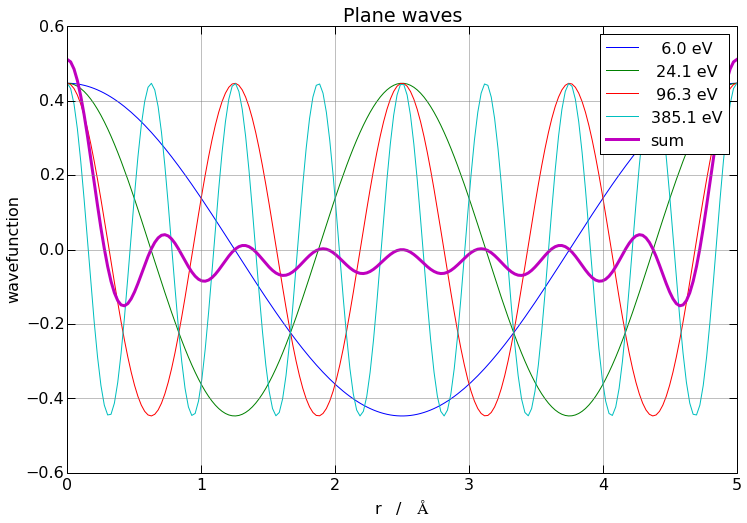

In [18]:
BOXLENGTH = 5
r = np.linspace(0, BOXLENGTH, 200)
spw = np.zeros(200)
for u in range(1, 9):
    pw = pw_1D(r, u, box=BOXLENGTH)
    spw += pw
    if u in [1, 2, 4, 8]:
        plt.plot(r, pw, label="{:5.1f} eV".format(e_kinet_pw(u, box=BOXLENGTH)), lw=1)

plt.plot(r, spw/7, label="sum", lw=3)
plt.title("Plane waves")
plt.xlabel("r   /   $\AA$")
plt.ylabel("wavefunction")
plt.legend()
plt.savefig("planewaves.pdf")

### Fit on a 3s atomoc orbital

#### General parameters and tools in order to do the fit

Parameters used for the fit.

In [13]:
BOXLENGTH = 5
rmax = 2
r = np.linspace(0, rmax, 100)

Fit function is defined such as the number of parameters set the number of used plane waves.

In [14]:
def pw_vector(x, *args):
    """ return the linear combination of plane waves """
    npar = len(args)
    return np.sum([args[u] * pw_1D(x, u + 1, box=BOXLENGTH, phi=0) for u in range(npar)], axis=0)

#### Hydrogen like atomic orbital

First, the case of a 3s hydrogen-like atomic orbital is considered.

  1 plane waves, ENCUT =     6.02 eV   rms =   4.6601
  5 plane waves, ENCUT =   150.41 eV   rms =   4.5154
 10 plane waves, ENCUT =   601.65 eV   rms =   3.6326
 20 plane waves, ENCUT =  2406.59 eV   rms =   1.9772
 40 plane waves, ENCUT =  9626.37 eV   rms =   0.9070
 50 plane waves, ENCUT = 15041.21 eV   rms =   0.7022


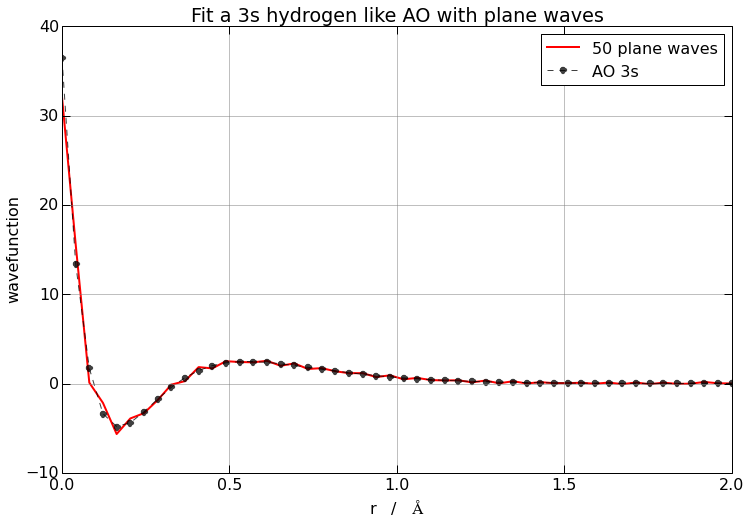

In [15]:
rp = np.linspace(0, rmax, 50)
for umax in [1, 5, 10, 20, 40, 50]:
    popt, pcov = curve_fit(pw_vector, r, OA3s(r), p0=np.ones(umax))
    ek = e_kinet_pw(umax, box=BOXLENGTH)
    valrms = rms(OA3s(r), pw_vector(r, *popt))
    print("{:3d} plane waves, ENCUT = {:8.2f} eV   rms = {:8.4f}".format(umax, ek, valrms))
    
    plt.plot(rp, pw_vector(rp, *popt), "r-", label="{} plane waves".format(umax), lw=2)
    plt.plot(rp, OA3s(rp), "ko--", label="AO 3s", alpha=.75)
    plt.legend()
    plt.title("Fit a 3s hydrogen like AO with plane waves")
    plt.xlabel("r   /   $\AA$")
    plt.ylabel("wavefunction")
    plt.ylim(-10, 40)
    plt.savefig("fit_AO3s_{}.pdf".format(umax))
    plt.clf()

plt.plot(rp, pw_vector(rp, *popt), "r-", label="{} plane waves".format(umax), lw=2)
plt.plot(rp, OA3s(rp), "ko--", label="AO 3s", alpha=.75)
plt.legend()
plt.ylim(-10, 40)
plt.title("Fit a 3s hydrogen like AO with plane waves")
plt.xlabel("r   /   $\AA$")
plt.ylabel("wavefunction")

#### smooth 3s atomic orbital

  1 plane waves, ENCUT =     6.02 eV   r^2 =   2.5843
  5 plane waves, ENCUT =   150.41 eV   r^2 =   0.7922
 10 plane waves, ENCUT =   601.65 eV   r^2 =   0.3621
 15 plane waves, ENCUT =  1353.71 eV   r^2 =   0.2102


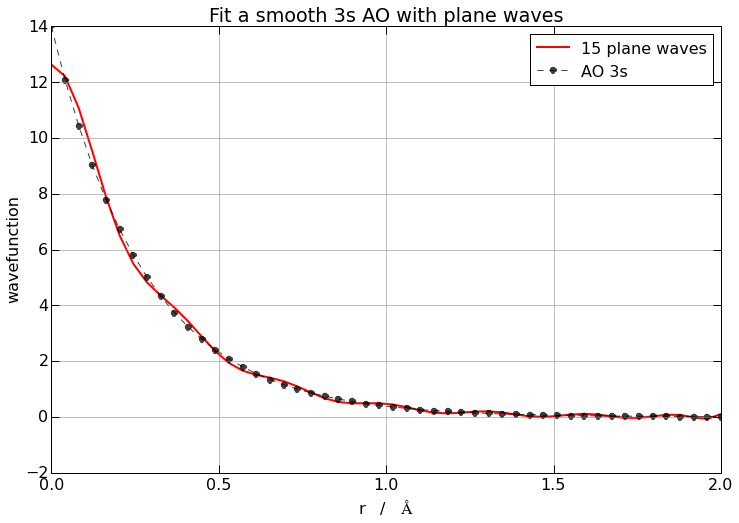

In [16]:
rp = np.linspace(0, rmax, 50)
for umax in [1, 5, 10, 15]:
    popt, pcov = curve_fit(pw_vector, r, smooth_3s(r), p0=np.ones(umax))
    ek = e_kinet_pw(umax, box=BOXLENGTH)
    valrms = rms(smooth_3s(r), pw_vector(r, *popt))
    print("{:3d} plane waves, ENCUT = {:8.2f} eV   r^2 = {:8.4f}".format(umax, ek, valrms))
    plt.plot(rp, pw_vector(rp, *popt), "r-", label="{} plane waves".format(umax), lw=2)

    plt.plot(rp, OA3s(rp), "ko--", label="AO 3s", alpha=.75)
    plt.legend()
    plt.title("Fit a smooth 3s AO with plane waves")
    plt.xlabel("r   /   $\AA$")
    plt.ylabel("wavefunction")
    plt.savefig("fit_smooth3s_{}.pdf".format(umax))
    plt.clf()

plt.plot(rp, pw_vector(rp, *popt), "r-", label="{} plane waves".format(umax), lw=2)
plt.plot(rp, smooth_3s(rp), "ko--", label="AO 3s", alpha=.75)
plt.legend()
plt.title("Fit a smooth 3s AO with plane waves")
plt.xlabel("r   /   $\AA$")
plt.ylabel("wavefunction")
smooth_popt = popt

#### Slater type atomic orbital

  1 plane waves, ENCUT =     6.02 eV   r^2 =   1.0939
  5 plane waves, ENCUT =   150.41 eV   r^2 =   0.7347
 10 plane waves, ENCUT =   601.65 eV   r^2 =   0.1954
 15 plane waves, ENCUT =  1353.71 eV   r^2 =   0.0695
 20 plane waves, ENCUT =  2406.59 eV   r^2 =   0.0293


(-1, 5)

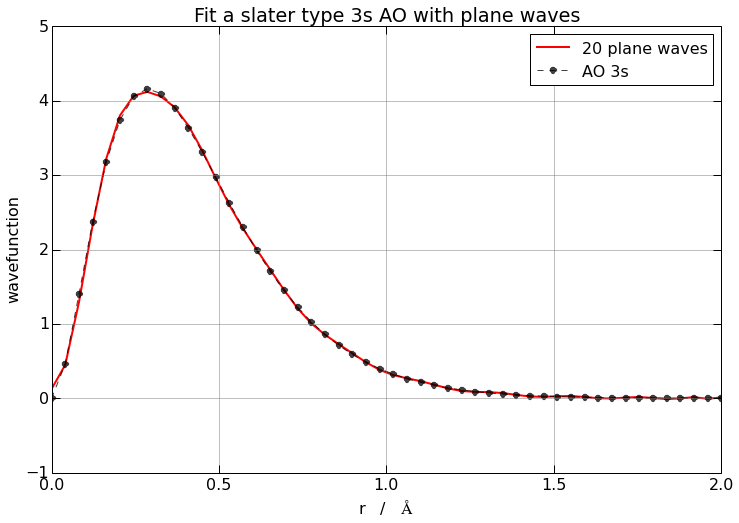

In [17]:
rp = np.linspace(0, rmax, 50)
for umax in [1, 5, 10, 15, 20]:
    popt, pcov = curve_fit(pw_vector, r, slater_ns(r, z=11, n=3), p0=np.ones(umax))
    ek = e_kinet_pw(umax, box=BOXLENGTH)
    valrms = rms(slater_ns(r, z=11, n=3), pw_vector(r, *popt))    
    print("{:3d} plane waves, ENCUT = {:8.2f} eV   r^2 = {:8.4f}".format(umax, ek, valrms))
    plt.plot(rp, pw_vector(rp, *popt), "r-", label="{} plane waves".format(umax), lw=2)

    plt.plot(rp, slater_ns(rp, z=11, n=3), "ko--", label="AO 3s", alpha=.75)
    plt.legend()
    plt.title("Fit a slater type 3s AO with plane waves")
    plt.xlabel("r   /   $\AA$")
    plt.ylabel("wavefunction")
    plt.ylim(-1, 5)
    plt.savefig("fit_slater3s_{}.pdf".format(umax))
    plt.clf()

plt.plot(rp, pw_vector(rp, *popt), "r-", label="{} plane waves".format(umax), lw=2)
plt.plot(rp, slater_ns(rp, z=11, n=3), "ko--", label="AO 3s", alpha=.75)
plt.legend()
plt.title("Fit a slater type 3s AO with plane waves")
plt.xlabel("r   /   $\AA$")
plt.ylabel("wavefunction")
plt.ylim(-1, 5)